In [35]:
# Describe the data
# samples = ['Illumina', 'Fasta short reads', 'Fasta long reads']
samples = ['Fasta short reads', 'Fasta long reads']
# input_illumina = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Illumina_simulated/Illumina_names_fixed.csv'
input_fasta_short = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Silva/Fasta_short_reads/Fasta_short_reads_names_fixed.csv'
input_fasta_long = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Silva/Fasta_long_reads/Fasta_long_reads_names_fixed.csv'
taxonomy_key = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/01_Collect_sequences/02_Sequences/Downloaded_5dec/Taxonomy_species_genus_corrected.csv'
conversion_table = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Species_conversion.txt'

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
# Read the data
# illumina = pd.read_csv(input_illumina, index_col='index')
fasta_short = pd.read_csv(input_fasta_short, index_col='Feature ID')
fasta_long = pd.read_csv(input_fasta_long, index_col='Feature ID')
taxonomy = pd.read_csv(taxonomy_key, index_col='Feature ID')
conversion = pd.read_csv(conversion_table)

taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

# Create a conversion dictionary for species with multiple names
conversion.columns = ['Species', 'Synonyms']
conversion_dict = {}
for ID in conversion.index:
    if conversion.loc[ID, 'Species'] not in conversion_dict.keys():
        conversion_dict[conversion.loc[ID, 'Species']] = [conversion.loc[ID, 'Synonyms']]
    else:
        conversion_dict[conversion.loc[ID, 'Species']].append(conversion.loc[ID, 'Synonyms'])

In [49]:
# Decide on the color maps for each taxonomic level, as well as for correct/incorrent classification
# Correct classification = Green
# Different taxonomic levels = Ligher or darker colors

# Number of taxonomic levels
n = len(taxonomic_levels)

# Create the color maps
cmap_correct = plt.cm.get_cmap('Blues', n+1)

color_levels = {}
for i in range(1, n+1):
    color_levels[taxonomic_levels[i-1]] = cmap_correct(i)

color_levels['Unassigned'] = 'orange'

In [40]:
fasta_short.drop('Confidence', axis=1, inplace=True)
fasta_long.drop('Confidence', axis=1, inplace=True)

### Without key

In [6]:
def find_class_levels_nokey(dataframe):
    '''Takes a dataframe and calculates the number of sequences that have been classified (not NA) to the different
    taxonomical levels regardless of if the classification is correct or not.
    Input: Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    Output: Two dataframes containing:
    - N° sequences (in total) classified at each level (C*1)
    - N° sequences that have each taxonomic level as their highest (1*C)'''

    # Number of unassigned
    ua = dataframe.value_counts('Kingdom')['Unassigned']

    # Count number of not-null cells at each taxonomic level (column)
    class_all_levels = dataframe.notnull().sum()
    class_all_levels['Kingdom'] = class_all_levels['Kingdom'] - ua
    class_highest_level = class_all_levels.copy(deep=True)

    # Loop through the levels and calculate the number of sequences with each level as their highest classification
    for level in range(len(class_all_levels)-1):
        class_highest_level[level] -= class_all_levels[level+1]
    class_all_levels = class_all_levels.to_frame()
    class_all_levels = pd.concat([class_all_levels, pd.DataFrame([6], index=['Unassigned'], columns=class_all_levels.columns)])

    class_highest_level = pd.concat([class_highest_level, pd.DataFrame([6], index=['Unassigned'], columns=class_all_levels.columns)])
    class_highest_level = class_highest_level.transpose()

    return class_all_levels, class_highest_level

In [50]:
# illumina_all, illumina_highest = find_class_levels_nokey(illumina)
fasta_short_all, fasta_short_highest = find_class_levels_nokey(fasta_short)
fasta_long_all, fasta_long_highest = find_class_levels_nokey(fasta_long)

all_all = pd.concat([fasta_short_all, fasta_long_all], axis=1)
all_all.columns = samples
all_highest = pd.concat([fasta_short_highest, fasta_long_highest])
all_highest.index = samples

all_highest_ratio = all_highest.copy(deep=True)
for sample in range(len(samples)):
    all_highest_ratio.iloc[sample,:] /= all_highest.iloc[sample,:].sum()

print(all_highest_ratio)

                    Kingdom  Phylum  Class  Order  Family     Genus  Species  \
Fasta short reads  0.085106       0      0      0       0  0.787234        0   
Fasta long reads   0.021277       0      0      0       0  0.851064        0   

                   Unassigned  
Fasta short reads     0.12766  
Fasta long reads      0.12766  


In [52]:
all_highest_ratio.columns = pd.CategoricalIndex(all_highest_ratio.columns.values, ordered=True, categories=['Unassigned'] + taxonomic_levels)
all_highest_ratio = all_highest_ratio.sort_index(axis=1)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_6780/2974233544.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


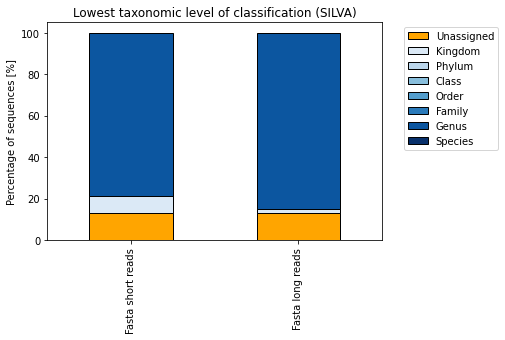

In [53]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
all_highest_ratio.plot(kind='bar', color=color_levels, edgecolor='Black', stacked=True, ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_title('Lowest taxonomic level of classification (SILVA)')
ax.set_ylabel('Percentage of sequences [%]')
plt.show()

### With key

In [13]:
# Find misclassified sequences
def find_misclassified(dataframe, correct_classification, conversion_table):
    # Create a copy to not mess with the original datafiles
    dataframe_genus_species = dataframe.applymap(lambda x: x.strip() if type(x)==str else x)
    taxonomy_genus_species = correct_classification.applymap(lambda x: x.strip() if type(x)==str else x)
    # dataframe_genus_species = dataframe.copy(deep=True)[['Genus', 'Species']]
    # taxonomy_genus_species = correct_classification.copy(deep=True)[['Genus', 'Species']]
    # taxonomy_genus_species['Genus'] = taxonomy_genus_species['Genus'].str.strip()
    # taxonomy_genus_species['Species'] = taxonomy_genus_species['Species'].str.strip()

    # Look through all sequences
    for ID in dataframe.index:
        # If the whole species name (genus + species) is the same as the taxonomy, the classification is correct
        # If only the species name is the same, it's maybe incorrect
        if dataframe_genus_species.loc[ID,'Species'] == taxonomy_genus_species.loc[ID,'Species']:
            if dataframe_genus_species.loc[ID,'Genus'] == taxonomy_genus_species.loc[ID,'Genus']:
                correct = 'Species'
            else:
                if not pd.isna(dataframe_genus_species.loc[ID,'Species']):
                    name = dataframe_genus_species.loc[ID,'Genus'] + ' ' + dataframe_genus_species.loc[ID,'Species']
                    tax = taxonomy_genus_species.loc[ID,'Genus'] + ' ' + taxonomy_genus_species.loc[ID,'Species']

                    if name in conversion_table.keys():
                        if tax in conversion_table[name]:
                            correct = 'Species'
        
        else:
            for level in reversed(dataframe.columns[:-1]):
                if dataframe_genus_species.loc[ID,level] == taxonomy_genus_species.loc[ID,level]:
                    correct = level
                    break
                else:
                    correct = 'Unassigned'
            if dataframe_genus_species.loc[ID, 'Kingdom'] != taxonomy_genus_species.loc[ID, 'Kingdom']:
                correct = 'Wrong kingdom'

        # Check if the incorrect classifications is because of redudant names by consulting the conversion table            
        dataframe_genus_species.loc[ID, 'Correct'] = correct

    return dataframe_genus_species

In [14]:
def classification_stats(dataframe):
    correct_sequences = dataframe['Correct'].value_counts()
    return pd.Series.to_frame(correct_sequences).transpose()

In [41]:
fasta_short['Phylum']=fasta_short['Phylum'].str.replace('Firmicutes', ' Bacillota')
fasta_long['Phylum']=fasta_long['Phylum'].str.replace('Firmicutes', ' Bacillota')

In [42]:
# illumina_misclassified = find_misclassified(illumina, taxonomy, conversion_dict)
fasta_short_misclassified = find_misclassified(fasta_short, taxonomy, conversion_dict)
fasta_long_misclassified = find_misclassified(fasta_long, taxonomy, conversion_dict)

# illumina_stats = classification_stats(illumina_misclassified)
fasta_short_stats = classification_stats(fasta_short_misclassified)
fasta_long_stats = classification_stats(fasta_long_misclassified)
all_stats = pd.concat([fasta_short_stats, fasta_long_stats])
all_stats.index = samples

all_stats_ratio = all_stats.copy(deep=True)
for sample in range(len(samples)):
    all_stats_ratio.iloc[sample,:] /= all_stats.iloc[sample,:].sum()

print(all_stats_ratio)

                    Kingdom     Genus  Wrong kingdom
Fasta short reads  0.636364  0.227273       0.136364
Fasta long reads   0.681818  0.204545       0.113636


In [43]:
all_stats_ratio.columns = pd.CategoricalIndex(all_stats_ratio.columns.values, ordered=True, categories=['Wrong kingdom'] + ['Unassigned'] + taxonomic_levels)
all_stats_ratio = all_stats_ratio.sort_index(axis=1)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_6780/4082572780.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


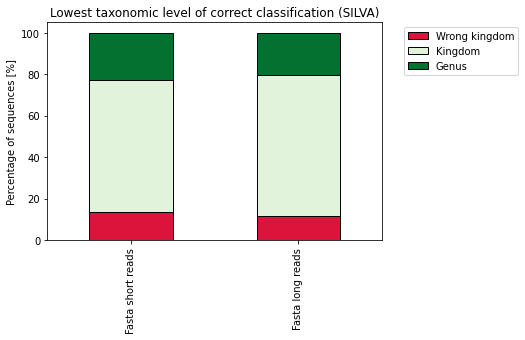

In [44]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
color_levels['Wrong kingdom'] = 'crimson'

fig, ax = plt.subplots()
all_stats_ratio.plot(kind='bar', color=color_levels, edgecolor='Black', stacked=True, ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_title('Lowest taxonomic level of correct classification (SILVA)')
ax.set_ylabel('Percentage of sequences [%]')
plt.show()